In [1]:
import pandas as pd
import plotly
from plotly import graph_objs
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, average_precision_score, confusion_matrix, roc_auc_score

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dvvsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dvvsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dvvsa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dvvsa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
df = pd.read_csv("data/labeled_data.csv", index_col=0)
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman woman you sho...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
df.shape

(24783, 6)

In [5]:
no_hate = len(df[df['class'] == 0])
no_offensive = len(df[df['class'] == 1])
no_neutral = len(df[df['class'] == 2])

print(no_hate)
print(no_offensive)
print(no_neutral)

1430
19190
4163


In [6]:
df = df.rename(columns={"class": 'target'})
df.head()

,count,hate_speech,offensive_language,neither,target,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman woman you sho...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
df.target = df.target.replace([2], 1)
df.target = df.target.replace([0, 1], [1, 0])
df.target.value_counts()

0    23353
1     1430
Name: target, dtype: int64

In [8]:
df.tweet.head(20)

0     !!! RT @mayasolovely: As a woman woman you sho...
1     !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2     !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3     !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4     !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5     !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...
6     !!!!!!"@__BrighterDays: I can not just sit up ...
7     !!!!&#8220;@selfiequeenbri: cause I'm tired of...
8     " &amp; you might not get ya bitch back &amp; ...
9     " @rhythmixx_ :hobbies include: fighting Maria...
10    " Keeks is a bitch she curves everyone " lol I...
11                   " Murda Gang bitch its Gang Land "
12    " So hoes that smoke are losers ? " yea ... go...
13        " bad bitches is the only thing that i like "
14                              " bitch get up off me "
15                      " bitch nigga miss me with it "
16                               " bitch plz whatever "
17                            " bitch who do you

In [9]:
def remove_users(df, col):
    df[col] = df[col].apply(lambda x: re.sub(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(x))) # remove re-tweet
    df[col] = df[col].apply(lambda x: re.sub(r'(@[A-Za-z0-9-_]+)', '', str(x))) # remove tweeted at

In [10]:
remove_users(df, 'tweet')

In [11]:
df.tweet.head(20)

0     !!! : As a woman woman you shouldn't complain ...
1     !!!!! : boy dats cold...tyga dwn bad for cuffi...
2     !!!!!!!  Dawg!!!! RT : You ever fuck a bitch a...
3                   !!!!!!!!! :  she look like a tranny
4     !!!!!!!!!!!!! : The shit you hear about me mig...
5     !!!!!!!!!!!!!!!!!!": The shit just blows me..c...
6     !!!!!!": I can not just sit up and HATE on ano...
7     !!!!&#8220;: cause I'm tired of you big bitche...
8     " &amp; you might not get ya bitch back &amp; ...
9     "  :hobbies include: fighting Mariam"\r\n\r\nb...
10    " Keeks is a bitch she curves everyone " lol I...
11                   " Murda Gang bitch its Gang Land "
12    " So hoes that smoke are losers ? " yea ... go...
13        " bad bitches is the only thing that i like "
14                              " bitch get up off me "
15                      " bitch nigga miss me with it "
16                               " bitch plz whatever "
17                            " bitch who do you

In [12]:
def remove_links(df, col):
    df[col] = df[col].apply(lambda x: re.sub(r'http\S+', '', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'bit.ly/\S+', '', str(x)))

In [13]:
df.tweet.head(20)

0     !!! : As a woman woman you shouldn't complain ...
1     !!!!! : boy dats cold...tyga dwn bad for cuffi...
2     !!!!!!!  Dawg!!!! RT : You ever fuck a bitch a...
3                   !!!!!!!!! :  she look like a tranny
4     !!!!!!!!!!!!! : The shit you hear about me mig...
5     !!!!!!!!!!!!!!!!!!": The shit just blows me..c...
6     !!!!!!": I can not just sit up and HATE on ano...
7     !!!!&#8220;: cause I'm tired of you big bitche...
8     " &amp; you might not get ya bitch back &amp; ...
9     "  :hobbies include: fighting Mariam"\r\n\r\nb...
10    " Keeks is a bitch she curves everyone " lol I...
11                   " Murda Gang bitch its Gang Land "
12    " So hoes that smoke are losers ? " yea ... go...
13        " bad bitches is the only thing that i like "
14                              " bitch get up off me "
15                      " bitch nigga miss me with it "
16                               " bitch plz whatever "
17                            " bitch who do you

In [14]:
remove_links(df, 'tweet')

In [15]:
df.tweet.head(20)

0     !!! : As a woman woman you shouldn't complain ...
1     !!!!! : boy dats cold...tyga dwn bad for cuffi...
2     !!!!!!!  Dawg!!!! RT : You ever fuck a bitch a...
3                   !!!!!!!!! :  she look like a tranny
4     !!!!!!!!!!!!! : The shit you hear about me mig...
5     !!!!!!!!!!!!!!!!!!": The shit just blows me..c...
6     !!!!!!": I can not just sit up and HATE on ano...
7     !!!!&#8220;: cause I'm tired of you big bitche...
8     " &amp; you might not get ya bitch back &amp; ...
9     "  :hobbies include: fighting Mariam"\r\n\r\nb...
10    " Keeks is a bitch she curves everyone " lol I...
11                   " Murda Gang bitch its Gang Land "
12    " So hoes that smoke are losers ? " yea ... go...
13        " bad bitches is the only thing that i like "
14                              " bitch get up off me "
15                      " bitch nigga miss me with it "
16                               " bitch plz whatever "
17                            " bitch who do you

In [16]:
def remove_special_char(df, col):
    df[col] = df[col].apply(lambda x: re.sub(r'&[\S]+?;', '', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'[^\w\s]', r'', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'#', ' ', str(x)))

In [17]:
remove_special_char(df, 'tweet')

In [18]:
df.tweet.head(20)

0       As a woman woman you shouldnt complain about...
1       boy dats coldtyga dwn bad for cuffin dat hoe...
2       Dawg RT  You ever fuck a bitch and she start...
3                                she look like a tranny
4       The shit you hear about me might be true or ...
5      The shit just blows meclaim you so faithful a...
6      I can not just sit up and HATE on another bit...
7      cause Im tired of you big bitches coming for ...
8          you might not get ya bitch back  thats that 
9          hobbies include fighting Mariam\r\n\r\nbitch
10     Keeks is a bitch she curves everyone  lol I w...
11                      Murda Gang bitch its Gang Land 
12        So hoes that smoke are losers   yea  go on IG
13           bad bitches is the only thing that i like 
14                                 bitch get up off me 
15                         bitch nigga miss me with it 
16                                  bitch plz whatever 
17                               bitch who do yo

In [19]:
def remove_whitespaces(df, col):
    """function to remove any double or more whitespaces to single and any leading and trailing whitespaces"""
    df[col] = df[col].apply(lambda x: re.sub(r'\s\s+', ' ', str(x))) 
    df[col] = df[col].apply(lambda x: re.sub(r'(\A\s+|\s+\Z)', '', str(x)))

In [20]:
remove_whitespaces(df, 'tweet')

In [21]:
df.tweet.head(20)

0     As a woman woman you shouldnt complain about c...
1     boy dats coldtyga dwn bad for cuffin dat hoe i...
2     Dawg RT You ever fuck a bitch and she start to...
3                                she look like a tranny
4     The shit you hear about me might be true or it...
5     The shit just blows meclaim you so faithful an...
6     I can not just sit up and HATE on another bitc...
7     cause Im tired of you big bitches coming for u...
8            you might not get ya bitch back thats that
9                 hobbies include fighting Mariam bitch
10    Keeks is a bitch she curves everyone lol I wal...
11                       Murda Gang bitch its Gang Land
12           So hoes that smoke are losers yea go on IG
13            bad bitches is the only thing that i like
14                                  bitch get up off me
15                          bitch nigga miss me with it
16                                   bitch plz whatever
17                                bitch who do y

In [22]:
def remove_numerics(df, col):
    """function to remove numbers or words with digits"""
    df[col] = df[col].apply(lambda x: re.sub(r'\w*\d\w*', r'', str(x)))

In [23]:
remove_numerics(df, 'tweet')

In [24]:
df.tweet.head(20)

0     As a woman woman you shouldnt complain about c...
1     boy dats coldtyga dwn bad for cuffin dat hoe i...
2     Dawg RT You ever fuck a bitch and she start to...
3                                she look like a tranny
4     The shit you hear about me might be true or it...
5     The shit just blows meclaim you so faithful an...
6     I can not just sit up and HATE on another bitc...
7     cause Im tired of you big bitches coming for u...
8            you might not get ya bitch back thats that
9                 hobbies include fighting Mariam bitch
10    Keeks is a bitch she curves everyone lol I wal...
11                       Murda Gang bitch its Gang Land
12           So hoes that smoke are losers yea go on IG
13            bad bitches is the only thing that i like
14                                  bitch get up off me
15                          bitch nigga miss me with it
16                                   bitch plz whatever
17                                bitch who do y

In [25]:
def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
    for token in word_tokens:    
        if token.lower not in stop_words and len(token) > 2:  # drops words with less than 3 characters
            result.append(lemmatize(token))
    return result

In [26]:
def tokenize_and_lemmatize(df, col):
    df[col] = df[col].apply(lambda x: tokenize(x))
    df.tweet = df.tweet.apply(lambda x: str(x)[1:-1])

In [27]:
tokenize_and_lemmatize(df, 'tweet')

In [28]:
df.head()

,count,hate_speech,offensive_language,neither,target,tweet
0,3,0,0,3,0,"'woman', 'woman', 'you', 'shouldnt', 'complain..."
1,3,0,3,0,0,"'boy', 'dats', 'coldtyga', 'dwn', 'bad', 'for'..."
2,3,0,3,0,0,"'Dawg', 'You', 'ever', 'fuck', 'bitch', 'and',..."
3,3,0,2,1,0,"'she', 'look', 'like', 'tranny'"
4,6,0,6,0,0,"'The', 'shit', 'you', 'hear', 'about', 'might'..."


In [29]:
#Train-Validation-Test Split
hate = df[df.target == 1]
non_hate = df[df.target == 0]

In [30]:
X_h = hate.tweet
y_h = hate.target
X_nh = non_hate.tweet
y_nh = non_hate.target

# perform 75-25 training-validation split and 15-10 validation-testing split on dataset
X_h_tr, X_h_val, y_h_tr, y_h_val = train_test_split(X_h, y_h, test_size=0.25, random_state=42)
X_h_val, X_h_tt, y_h_val, y_h_tt = train_test_split(X_h_val, y_h_val, test_size=0.4, random_state=42)
X_nh_tr, X_nh_val, y_nh_tr, y_nh_val = train_test_split(X_nh, y_nh, test_size=0.25, random_state=42)
X_nh_val, X_nh_tt, y_nh_val, y_nh_tt = train_test_split(X_nh_val, y_nh_val, test_size=0.4, random_state=42)

In [31]:
X_tr = pd.concat((X_h_tr, X_nh_tr), ignore_index=True)
y_tr = pd.concat((y_h_tr, y_nh_tr), ignore_index=True)
train = pd.concat([X_tr, y_tr], axis=1)

In [32]:
train.head()

,tweet,target
0,"'the', 'reject', 'niggas', 'who', 'constantly'...",1
1,"'will', 'convince', 'that', 'lame', 'you', 'ni...",1
2,"'Peace', 'fag', 'just', 'remember', 'best', 'L...",1
3,"'haha', 'ight', 'nig', 'calm', 'yoself'",1
4,"'your', 'tits', 'may', 'better', 'look', 'but'...",1


In [33]:
train.tweet

0        'the', 'reject', 'niggas', 'who', 'constantly'...
1        'will', 'convince', 'that', 'lame', 'you', 'ni...
2        'Peace', 'fag', 'just', 'remember', 'best', 'L...
3                  'haha', 'ight', 'nig', 'calm', 'yoself'
4        'your', 'tits', 'may', 'better', 'look', 'but'...
                               ...                        
18581                        'Miss', 'you', 'lil', 'bitch'
18582    'Why', 'you', 'get', 'such', 'hoe', 'smh', 'ai...
18583    'lmao', 'yeah', 'bitch', 'that', 'lil', 'shit'...
18584                          'tbt', 'be', 'bad', 'bitch'
18585    'These', 'hoe', 'act', 'you', 'know', 'what', ...
Name: tweet, Length: 18586, dtype: object

In [34]:
X_val = pd.concat((X_h_val, X_nh_val), ignore_index=True)
y_val = pd.concat((y_h_val, y_nh_val), ignore_index=True)
val = pd.concat([X_val, y_val], axis=1)

val.head()

,tweet,target
0,"'lbum', 'fotos', 'gaywrites', 'the', 'Making',...",1
1,"'Yay', 'for', 'America', 'Israel', 'put', 'mor...",1
2,"'miss', 'something', 'ofay', 'friends', 'Day',...",1
3,"'take', 'the', 'trash', 'out', 'and', 'darkski...",1
4,"'Cody', 'ALWAYS', 'call', 'people', 'nigger', ...",1


In [35]:
X_tt = pd.concat((X_h_tt, X_nh_tt), ignore_index=True)
y_tt = pd.concat((y_h_tt, y_nh_tt), ignore_index=True)
test = pd.concat([X_tt, y_tt], axis=1)

test.head()

,tweet,target
0,"'Johnny', 'Rebel', 'could', 'nigger', 'for', '...",1
1,"'favorite', 'nigger', 'work', 'the', 'plantati...",1
2,"'None', 'go', 'these', 'PRESTIGIOUS', 'establi...",1
3,"'WestVirginia', 'full', 'white', 'trash'",1
4,"'fuck', 'Brett', 'Farve', 'redneck', 'ass', 's...",1


In [36]:
X_tr = train.tweet
X_val = val.tweet
y_tr = train.target
y_val = val.target

# vectorize tweets for modeling
vec = TfidfVectorizer()
tfidf_tr = vec.fit_transform(X_tr)
tfidf_val = vec.transform(X_val)

In [37]:
def auc(X, y, model):
    """
        Function to calculate ROC-AUC Score based on predict_proba(X)
        where X is feature values, y is target values, and model is instantiated model variable
    """
    probs = model.predict_proba(X)[:,1] 
    return roc_auc_score(y, probs)

In [38]:
def aps(X, y, model):
    """
        Function to calculate PR-AUC Score based on predict_proba(X)
        where X is feature values, y is target values, and model is instantiated model variable
    """
    probs = model.predict_proba(X)[:,1]
    return average_precision_score(y, probs)

In [39]:

def get_metrics_confusion(X, y, y_pred, model):
    """
        Function to get accuracy, F1, ROC-AUC, recall, precision, PR-AUC scores followed by confusion matrix
        where X is feature dataset, y is target dataset, and model is instantiated model variable
    """
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = auc(X, y, model)
    rec = recall_score(y, y_pred)
    prec = precision_score(y, y_pred)
    pr_auc = aps(X, y, model)

    print('Accuracy: ', acc)
    print('F1 Score: ', f1)
    print('ROC-AUC: ', roc_auc)
    print('Recall: ', rec)
    print('Precision: ', prec)
    print('PR-AUC: ', pr_auc)
    
    cnf = confusion_matrix(y, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cnf.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cnf.flatten()/np.sum(cnf)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cnf, annot=labels, fmt='', cmap='Blues', annot_kws={'size':14}, cbar=False, xticklabels=False, yticklabels=False)

Accuracy:  0.9426957223567393
F1 Score:  0.009302325581395347
ROC-AUC:  0.6791668556457616
Recall:  0.004672897196261682
Precision:  1.0
PR-AUC:  0.14351153745929193


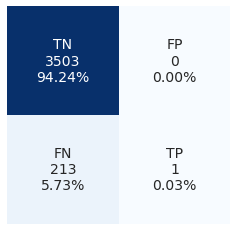

In [40]:
nb = MultinomialNB().fit(tfidf_tr, y_tr)
y_pred_nb = nb.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pred_nb, nb)

Accuracy:  0.9421576540220608
F1 Score:  0.14342629482071714
ROC-AUC:  0.8183392872864648
Recall:  0.08411214953271028
Precision:  0.4864864864864865
PR-AUC:  0.30595559599087246


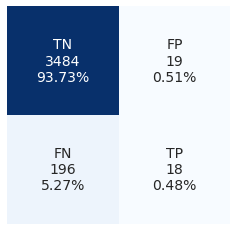

In [41]:
rf = RandomForestClassifier(n_estimators=100).fit(tfidf_tr, y_tr)
y_pred_rf = rf.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pred_rf, rf)

Accuracy:  0.9432337906914178
F1 Score:  0.16600790513833993
ROC-AUC:  0.8735863252058984
Recall:  0.09813084112149532
Precision:  0.5384615384615384
PR-AUC:  0.34745450079293605


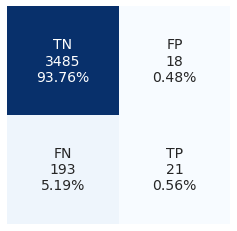

In [42]:
log = LogisticRegression().fit(tfidf_tr, y_tr)
y_pred_log = log.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pred_log, log)

Accuracy:  0.9394673123486683
F1 Score:  0.25742574257425743
ROC-AUC:  0.815950813855147
Recall:  0.1822429906542056
Precision:  0.43820224719101125
PR-AUC:  0.28930636339957816


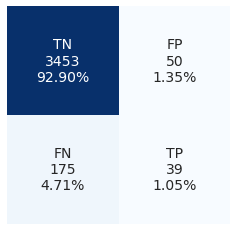

In [43]:
abc = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200
    ).fit(tfidf_tr, y_tr)
y_pred_abc = abc.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pred_abc, abc)

Accuracy:  0.9432337906914178
F1 Score:  0.16600790513833993
ROC-AUC:  0.8735556438940187
Recall:  0.09813084112149532
Precision:  0.5384615384615384
PR-AUC:  0.34783532085636276


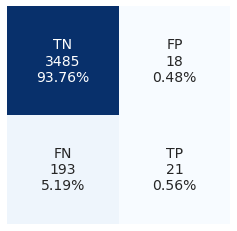

In [205]:
log = LogisticRegression().fit(tfidf_tr, y_tr)
y_pred_log = log.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pred_log, log)

Accuracy:  0.9418886198547215
F1 Score:  0.16923076923076924
ROC-AUC:  0.8390591775807652
Recall:  0.102803738317757
Precision:  0.4782608695652174
PR-AUC:  0.35373251344413625


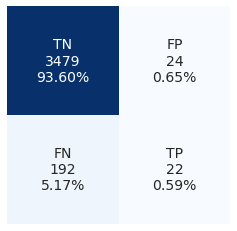

In [206]:
gbc = GradientBoostingClassifier().fit(tfidf_tr, y_tr)
y_pred_gbc = gbc.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pred_gbc, gbc)

In [ ]:
df.tweet.head(20)